# Homework 1

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

This homework relies on the data file, `treasury_quotes_2022-09-30`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `ITYPE` of 11 or 12, as these indicate a TIPS Note or TIPS bond.

#### #Update as of Jan 7 at 3pm*

Find more info about many of the fields in the data set at the following link,

https://www.crsp.org/products/documentation/treasno-properties

Find the complete manual for the CRSP Treasury data at the following link,

https://www.crsp.org/files/treasury_guide_0.pdf

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
%matplotlib inline
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import treasury_cmds

# Problem 1: Explore the Data

## 1 Maturity

For each issue, calculate its time-to-maturity, quoted in number of years, based on the issue and maturity dates. Assume a year has exactly 365.25 days.

In [6]:
treasury_path = 'C:/Users/dcste/OneDrive/fixed_income/fixed_income_FORKED/finm-fixedincome-2023/data/treasury_quotes_2022-09-30.xlsx'
data = pd.read_excel(treasury_path)
data.columns = data.columns.str.upper()
data.sort_values('TMATDT',inplace  = True)
data.set_index("KYTREASNO", inplace = True)
data.head()

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,20221004.400000,2022-09-30,99.973333,99.973444,99.973389,M,I,0.000000,-1.389258e-07,0.000067,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207774,20221006.400000,2022-09-30,99.960917,99.961083,99.961000,M,I,0.000000,-2.542594e-05,0.000065,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207893,20221011.400000,2022-09-30,99.924986,99.925292,99.925139,M,I,0.000000,1.473347e-05,0.000068,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207868,20221013.400000,2022-09-30,99.907556,99.907917,99.907736,M,I,0.000000,-8.270836e-05,0.000071,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207430,20221015.201370,2022-09-30,99.921875,99.953125,99.937500,M,I,0.631148,3.735728e-05,0.000079,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN


In [10]:
# checking if quotes all start on same date
t_check = data.CALDT.values[0]
if data.CALDT.eq(t_check).all() == True:
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates')
    t_current = None
print(f'Analysis is based on quotes from {pd.to_datetime(t_current):%Y-%m-%d}')

Analysis is based on quotes from 2022-09-30


In [102]:
metrics = data.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','TDYLD','duration','outstanding']
metrics.TDYLD *= 365
metrics.duration /= 365
metrics.outstanding *= 1e6
metrics['maturity'] = treasury_cmds.get_maturity_delta(metrics['maturity date'], t_current= t_current)
#dirty price
metrics['price'] = (data['TDBID']+ data['TDASK'])/2 + data['TDACCINT']
metrics['ask-bid'] = data['TDASK']-data['TDBID']
metrics['next cashflow date'] = (treasury_cmds.calc_cashflows(data) != 0).idxmax(1)

In [103]:

# Each security is sorted by maturity date measured in years
metrics

,issue date,maturity date,coupon rate,TDYLD,duration,outstanding,maturity,price,ask-bid,next cashflow date
KYTREASNO,,,,,,,,,,
207892,2022-06-07,2022-10-04,0.000,0.024286,0.010959,NaN,0.010951,99.973389,0.000111,2022-10-04
207774,2021-10-07,2022-10-06,0.000,0.023730,0.016438,NaN,0.016427,99.961000,0.000167,2022-10-06
207893,2022-06-14,2022-10-11,0.000,0.024850,0.030137,NaN,0.030116,99.925139,0.000306,2022-10-11
207868,2022-04-14,2022-10-13,0.000,0.025917,0.035616,NaN,0.035592,99.907736,0.000361,2022-10-13
207430,2019-10-15,2022-10-15,1.375,0.028740,0.041096,2.323500e+10,0.041068,100.568648,0.031250,2022-10-15
...,...,...,...,...,...,...,...,...,...,...
207808,2021-11-15,2051-11-15,1.875,0.037857,20.506232,6.897200e+10,29.125257,66.640625,0.046875,2022-11-15
207849,2022-02-15,2052-02-15,2.250,0.037800,19.982853,6.300400e+10,29.377139,72.718750,0.062500,2023-02-15
207850,2022-02-15,2052-02-15,0.125,NaN,NaN,1.663300e+10,29.377139,62.910156,0.257812,2023-02-15


## 2 Prices 

Calculate the "dirty" price for each bond issue as
$$\text{price} = \frac{1}{2}(\text{TDBID} + \text{TDASK}) + \text{TDACCINT}$$
Namely, you are taking the midpoint of the bid and ask prices, and then you add the accrued interest.

In [104]:
metrics

,issue date,maturity date,coupon rate,TDYLD,duration,outstanding,maturity,price,ask-bid,next cashflow date
KYTREASNO,,,,,,,,,,
207892,2022-06-07,2022-10-04,0.000,0.024286,0.010959,NaN,0.010951,99.973389,0.000111,2022-10-04
207774,2021-10-07,2022-10-06,0.000,0.023730,0.016438,NaN,0.016427,99.961000,0.000167,2022-10-06
207893,2022-06-14,2022-10-11,0.000,0.024850,0.030137,NaN,0.030116,99.925139,0.000306,2022-10-11
207868,2022-04-14,2022-10-13,0.000,0.025917,0.035616,NaN,0.035592,99.907736,0.000361,2022-10-13
207430,2019-10-15,2022-10-15,1.375,0.028740,0.041096,2.323500e+10,0.041068,100.568648,0.031250,2022-10-15
...,...,...,...,...,...,...,...,...,...,...
207808,2021-11-15,2051-11-15,1.875,0.037857,20.506232,6.897200e+10,29.125257,66.640625,0.046875,2022-11-15
207849,2022-02-15,2052-02-15,2.250,0.037800,19.982853,6.300400e+10,29.377139,72.718750,0.062500,2023-02-15
207850,2022-02-15,2052-02-15,0.125,NaN,NaN,1.663300e+10,29.377139,62.910156,0.257812,2023-02-15


## 3 YTM

#### #Update as of Jan 9, at 5pm.

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

## Helper Function for Yield-to-Maturity



In [105]:
from scipy.optimize import fsolve
def pv(rate, cashflows, maturities, freq = 1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i , cfi in enumerate(cashflows)])
    return price


In [106]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False
df_filter = treasury_cmds.filter_treasuries(data = data, t_date= t_current, filter_yld=RESTRICT_TIPS, filter_tips=RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF_matrix = treasury_cmds.filter_treasury_cashflows(treasury_cmds.calc_cashflows(df_filter), filter_maturity_dates=RESTRICT_DTS_MATURING)

In [107]:
CF_matrix

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0


In [46]:
from treasury_cmds import compound_rate

In [84]:
# First calculate the prices
px = (data[['TDASK', 'TDBID']].mean(axis=1)+ data['TDACCINT']).loc[CF_matrix.index]
# Calculating a maturity grid
maturity_grid = pd.Series(treasury_cmds.get_maturity_delta(CF_matrix.columns.values,t_current=t_current), index = CF_matrix.columns)
ytm = pd.DataFrame(index = px.index, columns= ['annual', 'semiannual', 'daily','continuous'], dtype=float)
for ibond in px.index:
    pv_wrapper = lambda y: px.loc[ibond] - pv(y,CF_matrix.loc[ibond,:].values, maturities=maturity_grid.values,freq=2)
    ytm.loc[ibond,"semiannual"] = fsolve(pv_wrapper,.01)
ytm['annual'] = compound_rate(ytm['semiannual'],2, 1)
ytm['daily'] = compound_rate(ytm['semiannual'], 2, 365)
ytm['continuous'] = compound_rate(ytm['semiannual'], 2, None)


In [85]:
ytm

,annual,semiannual,daily,continuous
KYTREASNO,,,,
207892,0.024600,0.024451,0.024303,0.024303
207774,0.024030,0.023887,0.023747,0.023746
207893,0.025178,0.025022,0.024867,0.024867
207868,0.026274,0.026103,0.025935,0.025935
207430,0.029178,0.028968,0.028761,0.028760
...,...,...,...,...
207763,0.038725,0.038357,0.037996,0.037994
207808,0.038609,0.038243,0.037884,0.037882
207849,0.038551,0.038186,0.037828,0.037826


In [86]:
compound_freq = 'continuous'
table = metrics.copy()[['maturity', 'price','coupon rate','TDYLD','ask-bid']]
table.insert(4,'yld',ytm[compound_freq])
table

,maturity,price,coupon rate,TDYLD,yld,ask-bid
KYTREASNO,,,,,,
207430,0.041068,100.568648,1.375,0.028740,0.028760,0.031250
207147,0.084873,100.761209,2.000,0.027870,0.027889,0.031250
206906,0.084873,100.693614,1.875,0.028483,0.028503,0.031250
207621,0.084873,99.817595,0.125,0.028853,0.028873,0.031250
206561,0.125941,100.449219,1.625,0.028645,0.028665,0.039062
...,...,...,...,...,...,...
207763,28.873374,68.367188,2.000,0.037968,0.037994,0.062500
207808,29.125257,66.640625,1.875,0.037857,0.037882,0.046875
207849,29.377139,72.718750,2.250,0.037800,0.037826,0.062500


Compare the provided YTM calculations to the ones you calculated

In [87]:
FREQ = 365.25
(data['TDYLD'].loc[CF_matrix.index]*FREQ - ytm[compound_freq]).describe().to_frame('Yield Error').T.style.format("{:.4%}")

,count,mean,std,min,25%,50%,75%,max
Yield Error,37800.0000%,-0.0001%,0.0001%,-0.0007%,-0.0001%,-0.0000%,0.0000%,0.0000%


My yield to maturity calculations are perfect

## 4 Summary Table

#### Correction: Jan 7, 3pm.
Field name was listed as `TDYTM` when it is actually `TDYLD`.
#### End correction

Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYLD | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYLD` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

In [88]:
table.describe()

,maturity,price,coupon rate,TDYLD,yld,ask-bid
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,7.145816,92.754431,2.187883,0.040571,0.040599,0.043975
std,8.230273,9.542800,1.512281,0.002684,0.002686,0.015405
min,0.041068,56.304688,0.125000,0.027870,0.027889,0.007812
25%,1.623546,87.665757,1.250000,0.039843,0.039870,0.031250
50%,3.644079,94.720109,2.125000,0.041082,0.041110,0.046875
75%,7.561259,98.007897,2.875000,0.042461,0.042491,0.046875
max,29.875428,117.296875,7.625000,0.043562,0.043592,0.140625


## 5 Plots

Create a scatter plot of maturity versus price for all issues.

t_current


Text(0.5, 1.0, 'Price of Bonds as a function of maturity date')

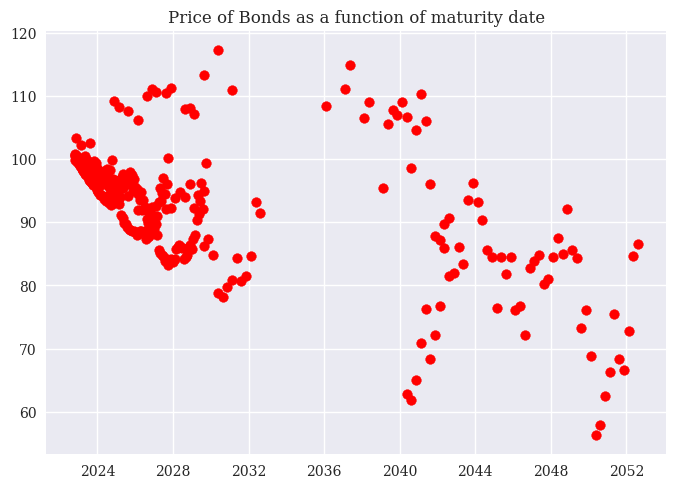

In [89]:
plt.scatter(metrics['maturity date'],metrics['price'], c = 'red')
plt.title('Price of Bonds as a function of maturity date')

Prices of long-term bonds have been getting hammered since the recent monetary policy decisions. 

## 6 Bad Data?

Find the issues where `TDYTM` is `NaN`. Display these rows from your table above. How many issues (rows) are effected?

What do you see in the other metrics for these issues that suggests that the price is bad?

# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

You will need to make a few modeling choices to do this...
* eliminate any treasury that does not report `TDYTM` or that reports a negative number for `TDYTM`.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [108]:
from treasury_cmds import bootstrap, filter_treasuries, filter_treasury_cashflows, calc_cashflows, estimate_rate_curve
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True
treasury_filter_df = filter_treasuries(data= data, t_date=t_current,filter_yld=RESTRICT_YLD, filter_tips=RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(treasury_filter_df), filter_maturity_dates=RESTRICT_DTS_MATURING)

In [111]:
prices = metrics['price'][CF.index]
params_boot = estimate_rate_curve(model = MODEL, t_current=t_current,prices = prices, CF = CF)

Text(0.5, 1.0, 'Bootstraped Discount Factor Curve')

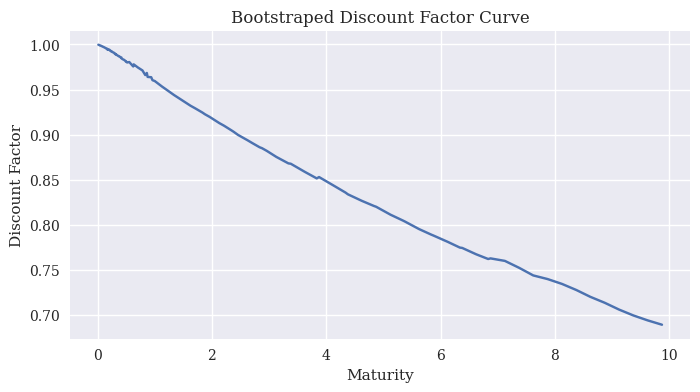

In [119]:
plt.figure(figsize=(8,4))
plt.plot(params_boot[0],params_boot[1])
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')
plt.title('Bootstraped Discount Factor Curve')

<AxesSubplot:xlabel='Maturity'>

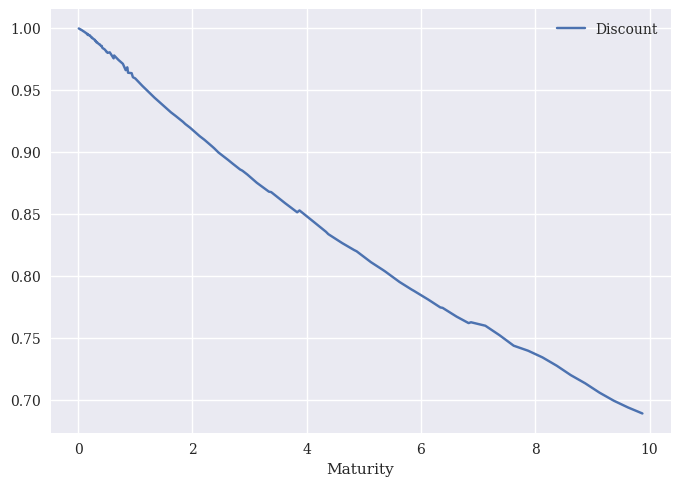

In [130]:
discount_df = pd.DataFrame({'Discount':params_boot[1], 'Maturity':params_boot[0]}).set_index('Maturity')
discount_df.plot()

,Discount
Maturity,
0.010951,0.999734
0.016427,0.999610
0.030116,0.999251
0.035592,0.999077
0.041068,0.998820
...,...
8.873374,0.713645
9.125257,0.706076
9.377139,0.699534


## 2 Bootstrap

Bootstrap the discount factors.

Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

The three step procedure below might be useful.

1. For dates with multiple bonds maturing, keep only that with the smallest bid-ask. If there are still multiple bonds maturing on the date, keep only that with the smallest coupon.

2. Only keep the first $L$ columns of the cashflow matrix, such that every column has a bond maturing.

3. Eliminate any bonds, (rows,) that had maturity beyond column $L$.

This should produce the cashflow matrix, $\tilde{C}$.

**Report 5 head and tail rows of $\tilde{C}$.**

Solve the system of equations
$$\textbf{p} = \tilde{\textbf{C}}\, \textbf{z}_{\text{bootstrap}}$$

**Plot the estimated discount factors, $\textbf{z}$, against time-to-maturity.**

## 3. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. (You might do something similar to the three-step procedure of the bootstrap, but skip step #1.) Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

**Plot the discount factors against maturities.**

## 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates

Do the same for $\textbf{z}_{\text{ols}}$.

Plot the **continuous** discount rates generated via bootstrap and via OLS against time-to-maturity.

Plot the **semiannually compounded** discount rates generated via bootstrap and via OLS against time-to-maturity.

In [133]:
inc = .5
mature_grid = np.arange(inc, discount_df.index.to_series().max()+.5,inc)
spot_curve = pd.DataFrame(index = mature_grid)
#bootstrap creates the spot curve
spot_curve['bootstrap'] = bootstrap(params_boot,maturity=mature_grid)

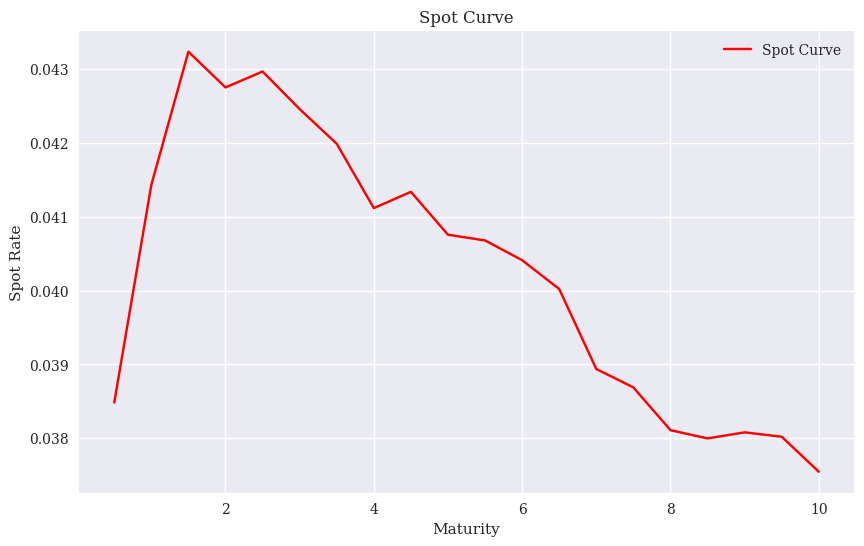

In [139]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(spot_curve['bootstrap'], label = 'Spot Curve', c = 'red')
ax.set_title('Spot Curve')
ax.set_xlabel('Maturity')
ax.set_ylabel('Spot Rate')
ax.legend(loc = 0)


array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

# Problem 3: Nelson-Siegel Curve
## *Optional*

No need to submit this problem, but if we discuss it, then you are expected to know it.

Use the Nelson-Siegel curve to model the discount rates. 

Fit them via minimizing the sum of squared errors for the prices imputed by the model versus the quoted prices. 

You might try estimating via non-linear least squares.

Estimate the model three times, using $\textbf{C}$, $\tilde{\textbf{C}}$, $\hat{\textbf{C}}$.

Plot the estimated discount factors, $\textbf{z}_{\text{ns}}$ against time-to-maturity.

Also plot the associated continuously-compounded discount rates.